In [206]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

In [207]:
df = pd.read_csv('preprocessed/data24h.csv', index_col=0, parse_dates=True)
df_pm = df['MpKrakZloRog'].copy()
df_pm = df_pm.to_frame()

In [208]:
for lag in range(1, 8):
     df_pm[f"lag_{lag}"] = df_pm['MpKrakZloRog'].shift(lag)

In [209]:
df_pm = df_pm.dropna()

In [210]:
df["avg_7days"] = df["MpKrakZloRog"].shift(1).rolling(window=7, min_periods=1).mean()
# shift prevents data leakage

In [211]:
df = df.drop(['day_off', 'rainIntensity'], axis=1)
df = df.dropna()

In [213]:
X = df.iloc[:, 1:]
y = df['MpKrakZloRog']

In [216]:
y

2016-01-02     49.00
2016-01-03     56.00
2016-01-04     92.00
2016-01-05    133.00
2016-01-06    133.00
               ...  
2023-12-27     22.75
2023-12-28     41.58
2023-12-29     20.02
2023-12-30     12.88
2023-12-31     27.16
Name: MpKrakZloRog, Length: 2921, dtype: float64

In [224]:
X_train = X[X['year'] <= 2021]
X_test = X[X['year'] > 2021]
y_train = y[y['MpKrakZloRog'] <= 2021]
y_test = y[y['MpKrakZloRog'] > 2021]

In [225]:
y.index

((2191, 11), (730, 11), (2191,), (730,))

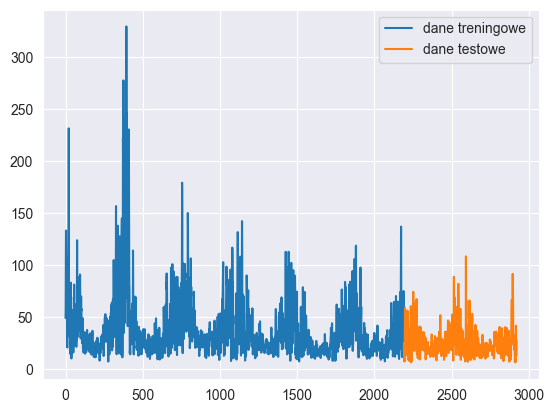

In [226]:
plt.plot(range(len(y_train)), y_train, label='dane treningowe')
plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, label='dane testowe')
plt.legend()
plt.show()

In [227]:
df.var()

MpKrakZloRog               659.112920
averageAirTemp              65.903141
averageRelativeHumidity    117.902074
averageAirPressure          87.598313
maxWindSpeed                 4.394481
averageWindSpeed             0.570981
year                         5.250086
month_sin                    0.498349
month_cos                    0.501964
sin_WindDir                  0.588385
cos_WindDir                  0.218845
avg_7days                  417.692352
dtype: float64

In [228]:
print(f'Wariancja dla całych danych {y.var():.2f}')
print(f'Wariancja dla danych treningowych {y_train.var():.2f}')
print(f'Wariancja dla danych testowych {y_test.var():.2f}')

Wariancja dla całych danych 659.11
Wariancja dla danych treningowych 780.54
Wariancja dla danych testowych 191.29


### Random Forest

In [229]:
# random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree

In [230]:
regressor = RandomForestRegressor(n_estimators=200, random_state=44, oob_score=True, bootstrap=True)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [231]:
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score:.4f}')
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')
# all params + 7 days avg
# no significant differences when changing n_estimators
# no improvement with train/test size
# problem - different variance

Out-of-Bag Score: 0.4326
Mean Squared Error: 176.1711
R-squared: 0.0778


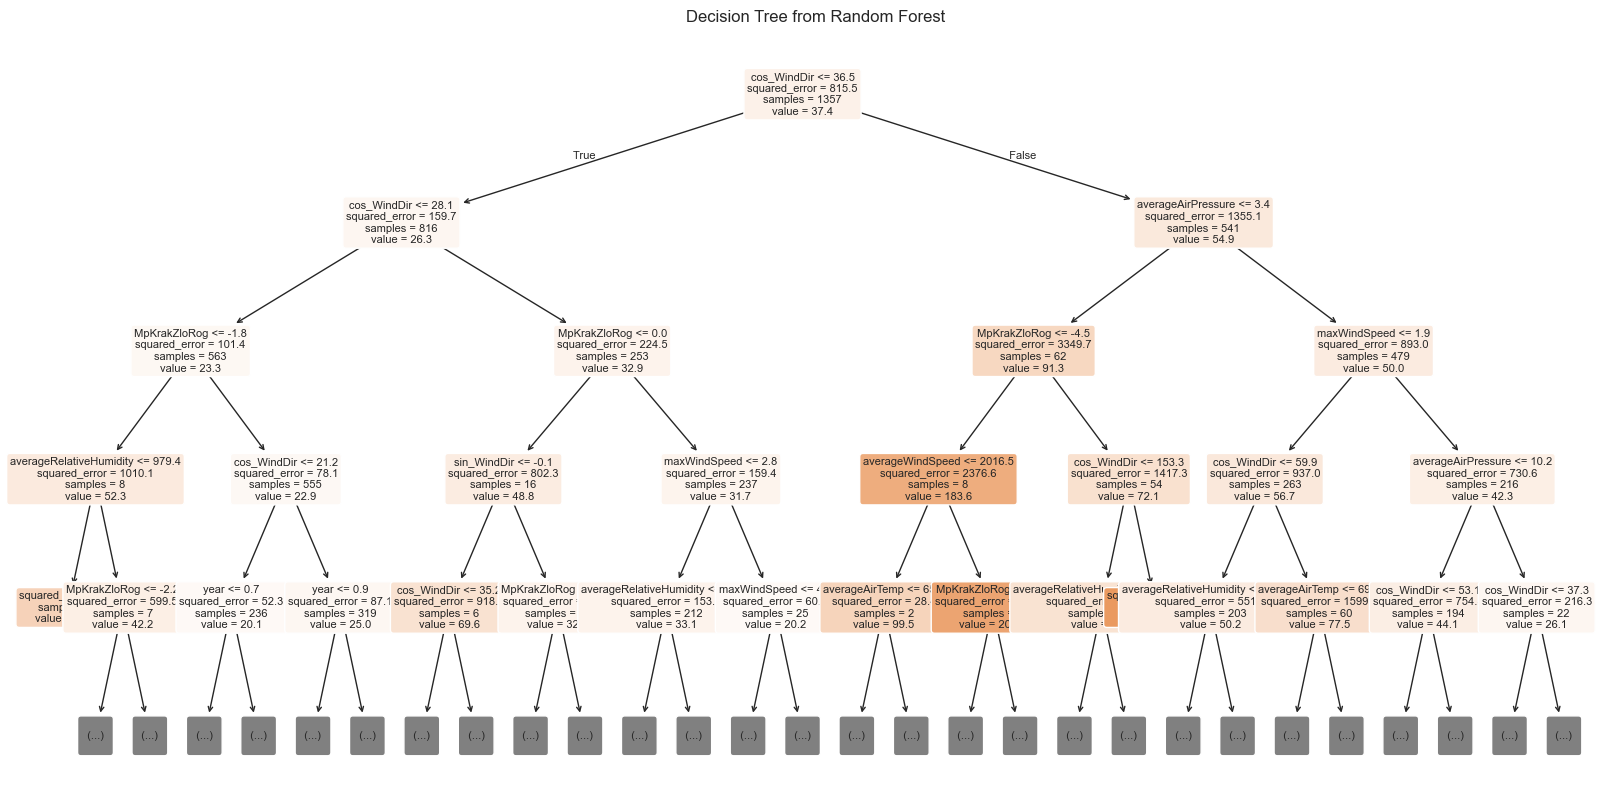

In [232]:
tree_to_plot = regressor.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df.columns.tolist(), filled=True, rounded=True, fontsize=8, precision=1, max_depth=4)
plt.title("Decision Tree from Random Forest")
plt.show()

In [235]:
X_pm = df_pm.iloc[:, 1:]
y_pm = df_pm['MpKrakZloRog']

X_train_pm, y_train_pm = X_pm.iloc[:2500, :], y_pm[:2500]
X_test_pm, y_test_pm = X_pm.iloc[2500:, :], y_pm[2500:]

In [236]:
# just lags
# similar statistics
regressor.fit(X_train_pm, y_train_pm)
y_pred_pm = regressor.predict(X_test_pm)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score:.4f}')
mse = mean_squared_error(y_test_pm, y_pred_pm)
print(f'Mean Squared Error: {mse:.4f}')
r2 = r2_score(y_test_pm, y_pred_pm)
print(f'R-squared: {r2:.4f}')


Out-of-Bag Score: 0.5284
Mean Squared Error: 131.9883
R-squared: 0.3703


In [237]:
df_all = pd.concat([df, df_pm], axis=1)
df_all = df_all.dropna()

X_all = df_all.iloc[:, 1:]
y_all = df_all['MpKrakZloRog']

X_train_all, y_train_all = X_all.iloc[:2500, :], y_all[:2500]
X_test_all, y_test_all = X_all.iloc[2500:, :], y_all[2500:]

regressor.fit(X_train_all, y_train_all)
y_pred_all = regressor.predict(X_test_all)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score:.4f}')
mse = mean_squared_error(y_test_all, y_pred_all)
print(f'Mean Squared Error: {mse:.4f}')
r2 = r2_score(y_test_all, y_pred_all)
print(f'R-squared: {r2:.4f}')
# data leakage - where

Out-of-Bag Score: 0.9933
Mean Squared Error: 0.0053
R-squared: 1.0000


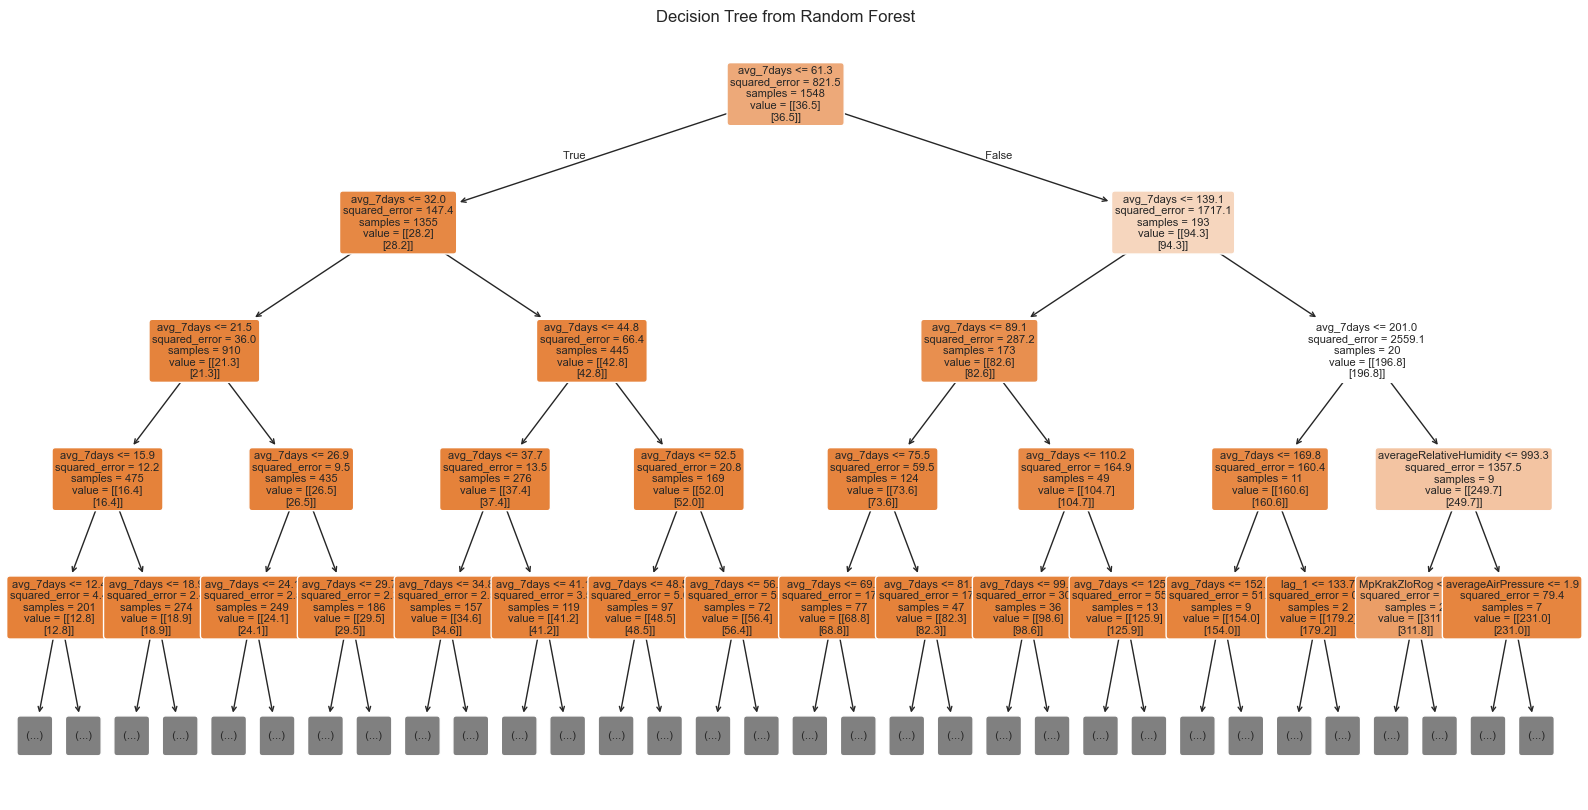

In [238]:
tree_to_plot = regressor.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=df_all.columns.tolist(), filled=True, rounded=True, fontsize=8, precision=1, max_depth=4)
plt.title("Decision Tree from Random Forest")
plt.show()

In [141]:
print(df_all[["MpKrakZloRog", "avg_7days", "lag_1", "lag_2", "lag_3"]].corr())


              MpKrakZloRog  MpKrakZloRog  avg_7days     lag_1     lag_2  \
MpKrakZloRog      1.000000      1.000000   0.705062  0.753368  0.566047   
MpKrakZloRog      1.000000      1.000000   0.705062  0.753368  0.566047   
avg_7days         0.705062      0.705062   1.000000  0.782318  0.823864   
lag_1             0.753368      0.753368   0.782318  1.000000  0.754124   
lag_2             0.566047      0.566047   0.823864  0.754124  1.000000   
lag_3             0.469879      0.469879   0.839084  0.567484  0.755345   

                 lag_3  
MpKrakZloRog  0.469879  
MpKrakZloRog  0.469879  
avg_7days     0.839084  
lag_1         0.567484  
lag_2         0.755345  
lag_3         1.000000  


### XGBoost

In [29]:
import xgboost as xg 
from sklearn.model_selection import GridSearchCV

In [30]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, seed = 44) 
xgb_r.fit(X_train, y_train) 
y_pred = xgb_r.predict(X_test) 

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 38.0736
R-squared: 0.6899


In [38]:
train_dmatrix = xg.DMatrix(data = X_train, label = y_train) 
test_dmatrix = xg.DMatrix(data = X_test, label = y_test) 

n_estimators = 300
param = {'objective': 'reg:squarederror', 
        'colsample_bytree': 0.95, # 1 the best
        'gamma': 0,
        'learning_rate': 0.05,
        'max_depth': 8,
        'reg_alpha': 0.015,
        'reg_lambda': 0.01,
        'subsample': 0.75}
xbg_rhp = xg.train(param, train_dmatrix, n_estimators)
y_pred = xbg_rhp.predict(test_dmatrix)

In [32]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Roof of MSE: {np.sqrt(mse)}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 29.5772
Roof of MSE: 5.43849347769484
R-squared: 0.7591


In [33]:
param_grid = {
    'learning_rate': [0.03, 0.05],
    'max_depth': [7, 8],
    'subsample': [0.75, 0.85],
    'reg_alpha': [0.01, 0.015],
    'reg_lambda': [0.01, 0.015],
    'gamma': [0, 0.02]
}
grid_search = GridSearchCV(estimator=xg.XGBRegressor(), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1, n_jobs=2)

In [34]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=2,
             param_grid={'gamma': [0, 0.02], 'learning_rate': [0.03, 0.05],
                         'max_depth': [7, 8], 'reg_alpha': [0.01, 0.015],
                         'reg_lambda': [0.01, 0.015],
                         'subsample': [0.75, 0.85]},
             scoring='neg_mean_squared_error', verbose=1)

In [35]:
grid_search.best_params_

{'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 8,
 'reg_alpha': 0.015,
 'reg_lambda': 0.01,
 'subsample': 0.75}

In [40]:
#y_pred = grid_search.best_estimator_(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root of Mean Squared Error: {np.sqrt(mse):.4f}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2:.4f}')

Mean Squared Error: 29.5772
Root of Mean Squared Error: 5.4385
R-squared: 0.7591


XGBoost ma już niższy błąd $MSE = 0.29$, ale także zwiększył się współczynnik $R^2$.
Zmiana parametrów pogarszała wyniki.
Wysokie błedy wynikają prawdopodobnie ze stosunkowo małego zbioru danych i braku silnych zależności z cechami - zwiększenie zbioru testowego poprawiło wyniki. 

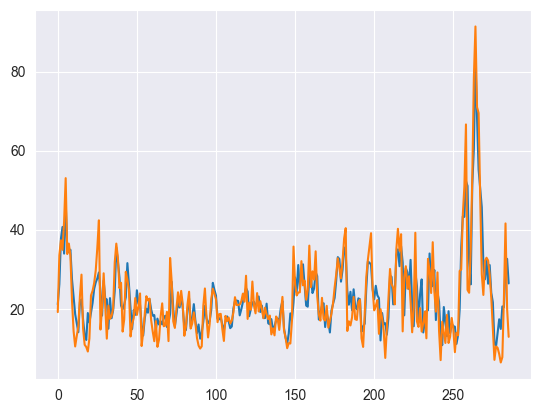

In [52]:
plt.plot(range(len(y_pred)), y_pred)
plt.plot(range(len(y_pred)), y_test)